# AML - Assignment 12
## Paarth Iyer  -  MCS202218

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
import random

from tqdm import tqdm

In [ ]:
RANDOM_SEED = 432
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Helper functions


In [ ]:
def plot_sample(
    image_batch: torch.Tensor,
    label_batch: torch.Tensor|None = None,
    figsize=(8, 8),
    num_images=6,
    num_cols = 3,
    start_at = 0,
    cmap="gray",
    class_names=None
):
    plt.figure(figsize=figsize)

    for i in range(start_at, start_at+num_images):
        image = image_batch[i]
        
        plt.subplot(num_images//num_cols + 1, num_cols, i+1)
        
        plt.imshow(image.squeeze().numpy(), cmap=cmap)
        plt.axis("off")
        
        if label_batch!= None:
            label = label_batch[i].item()
            plt.title(label if class_names is None else class_names[label])
        
    plt.show()
    plt.close()

# VAE

VAE trained on the Fashion MNIST dataset

## VAE architecture

In [ ]:
class VAE(nn.Module):
    def __init__(self, d=50):

        super(VAE, self).__init__()
        
        self.d = d
        self.device = device
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 200),
            nn.LeakyReLU(0.2),
            nn.Linear(200, 2 * d),
            nn.LeakyReLU(0.2),
        )
        
         
        self.decoder = nn.Sequential(
            nn.Linear(d, 200),
            nn.LeakyReLU(0.2),
            nn.Linear(200, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(0.2),
            nn.Linear(1000, 784),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (1,28, 28))
        )
        
    def device_change(self, dev):
        self.device = dev
        
    def sample(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(logvar)
            return mu + std*eps
        else: 
            return mu
        
    def generate(self, N=10, dev = device):
        z = torch.randn((N, self.d)).to(dev)
        return self.decoder(z)
    
    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 1, 28, 28))
        mu, logvar = torch.chunk(mu_logvar, chunks=2, dim=1)
        z = self.sample(mu, logvar)
        return self.decoder(z), mu, logvar

In [ ]:
def VAE_loss(x_hat, x, mu, logvar, beta=1):
    mse_loss = F.mse_loss(x_hat, x.view(-1, 1, 28, 28), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    return mse_loss + beta*KLD
    

### Fashion MNIST

In [ ]:
# set input as image dims and output as number of classes
input_size = 28 * 28
output_size = 10

# set class names
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

# loading the train and test datasets into datalaoder
fashion_train = DataLoader(
    datasets.FashionMNIST(
        root="../data", train=True, download=True, transform=ToTensor()
    ),
    batch_size=64,
    shuffle=True,
    num_workers=4
)


fashion_test = DataLoader(
    datasets.FashionMNIST(
        root="../data", train=False, download=True, transform=ToTensor()
    ),
    batch_size=32,
    shuffle=True,
    num_workers=4
)

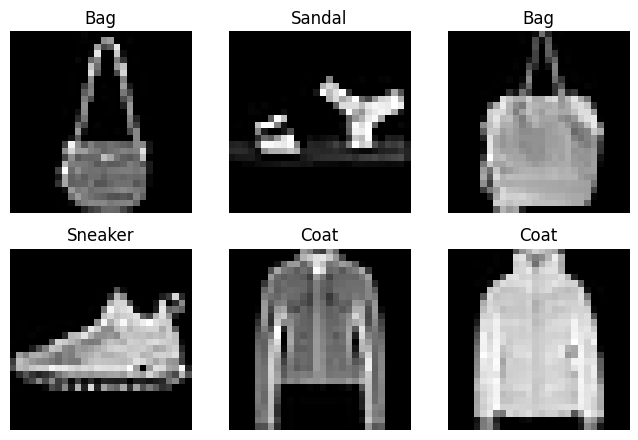

In [ ]:
a = next(iter(fashion_train))
plot_sample(a[0], a[1], class_names=class_names)

The latent dim is set to 50. The optimizer used is ADAM with lr = 0.0001

In [ ]:
latent_dim=50
fashion_vae = VAE(latent_dim).to(device)
fashion_vae.device_change(device)

# Setting the optimiser
learning_rate = 1e-4
optimizer = torch.optim.Adam(
    fashion_vae.parameters(),
    lr=learning_rate,
)

### Training

In [ ]:
epochs = 50

epoch_data = dict(mu=list(), logvar=list(), loss=list(), labels=list())

Test loss = 5070.675849


Epoch 0: 100%|█████████▉| 937/938 [00:15<00:00, 79.59it/s, loss : 1001.35 | Global : 2936.85]

Epoch 0 Average loss : 1.0675
Test loss = 1086.015842


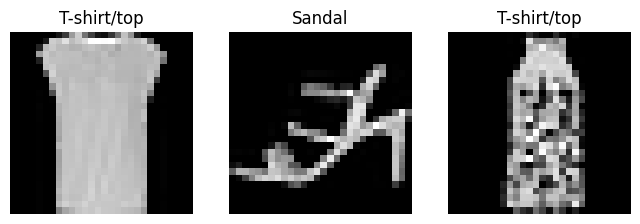

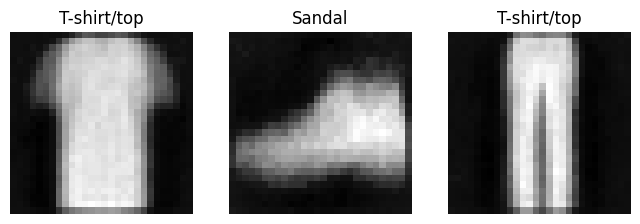

Epoch 0: 100%|██████████| 938/938 [00:21<00:00, 44.61it/s, loss : 1001.35 | Global : 2936.85]


Epoch 1 Average loss : 1.0842
Test loss = 928.084187


Epoch 2: 100%|█████████▉| 937/938 [00:15<00:00, 81.27it/s, loss : 1016.99 | Global : 2316.51]

Epoch 2 Average loss : 1.0842
Test loss = 853.797780


Epoch 2: 100%|██████████| 938/938 [00:21<00:00, 44.64it/s, loss : 1016.99 | Global : 2316.51]


Epoch 3 Average loss : 1.0480
Test loss = 827.946833


Epoch 4: 100%|█████████▉| 937/938 [00:15<00:00, 78.54it/s, loss : 899.57 | Global : 2108.77] 

Epoch 4 Average loss : 0.9590
Test loss = 780.221456


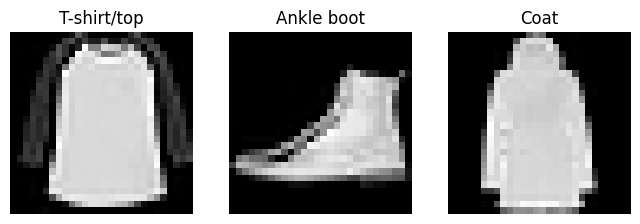

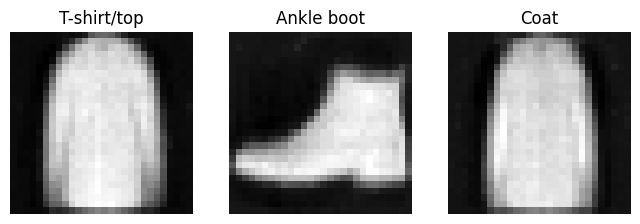

Epoch 4: 100%|██████████| 938/938 [00:21<00:00, 44.26it/s, loss : 899.57 | Global : 2108.77]


Epoch 5 Average loss : 0.8605
Test loss = 777.477569


Epoch 6: 100%|█████████▉| 937/938 [00:15<00:00, 78.07it/s, loss : 853.72 | Global : 1994.91] 

Epoch 6 Average loss : 0.9102
Test loss = 773.147991


Epoch 6: 100%|██████████| 938/938 [00:20<00:00, 45.69it/s, loss : 853.72 | Global : 1994.91]


Epoch 7 Average loss : 0.8583
Test loss = 742.910844


Epoch 8: 100%|█████████▉| 937/938 [00:15<00:00, 81.60it/s, loss : 870.33 | Global : 1921.62] 

Epoch 8 Average loss : 0.9279
Test loss = 754.295539


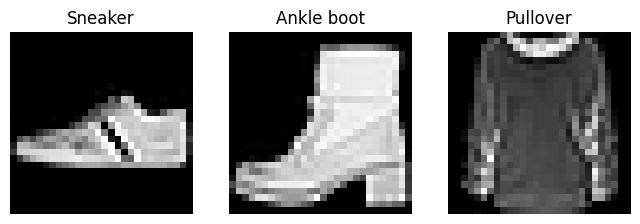

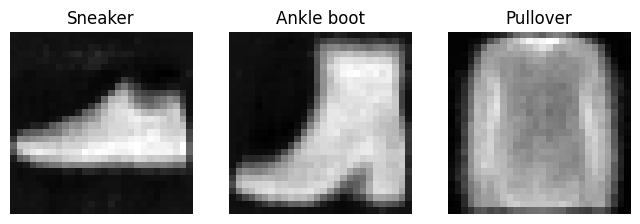

Epoch 8: 100%|██████████| 938/938 [00:21<00:00, 44.09it/s, loss : 870.33 | Global : 1921.62]


Epoch 9 Average loss : 0.8587
Test loss = 752.292985


Epoch 10: 100%|█████████▉| 937/938 [00:15<00:00, 81.04it/s, loss : 799.05 | Global : 1869.68] 

Epoch 10 Average loss : 0.8519
Test loss = 736.710932


Epoch 10: 100%|██████████| 938/938 [00:21<00:00, 44.26it/s, loss : 799.05 | Global : 1869.68]


Epoch 11 Average loss : 0.8018
Test loss = 739.985008


Epoch 12: 100%|█████████▉| 937/938 [00:15<00:00, 80.44it/s, loss : 788.71 | Global : 1830.48] 

Epoch 12 Average loss : 0.8408
Test loss = 729.157642


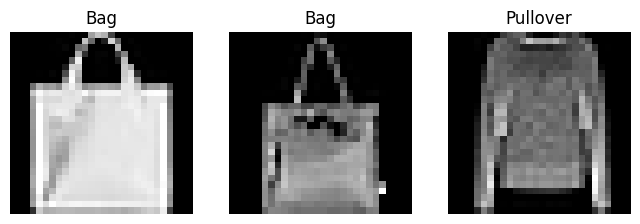

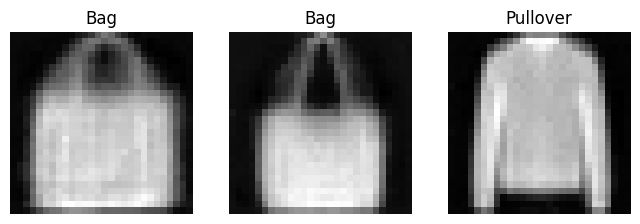

Epoch 12: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s, loss : 788.71 | Global : 1830.48]


Epoch 13 Average loss : 0.9688
Test loss = 733.707588


Epoch 14: 100%|█████████▉| 937/938 [00:15<00:00, 82.53it/s, loss : 849.78 | Global : 1799.45] 

Epoch 14 Average loss : 0.9059
Test loss = 727.501965


Epoch 14: 100%|██████████| 938/938 [00:20<00:00, 45.75it/s, loss : 849.78 | Global : 1799.45]


Epoch 15 Average loss : 0.8585
Test loss = 727.023596


Epoch 16: 100%|██████████| 938/938 [00:15<00:00, 76.51it/s, loss : 841.52 | Global : 1774.26] 

Epoch 16 Average loss : 0.8971
Test loss = 717.281905


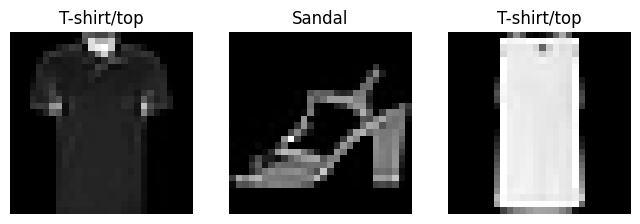

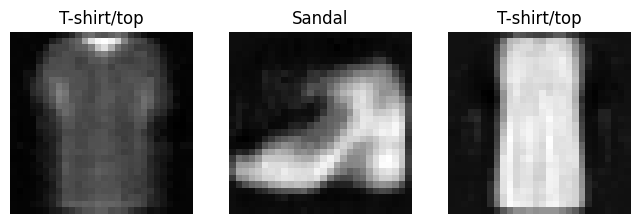

Epoch 16: 100%|██████████| 938/938 [00:21<00:00, 44.60it/s, loss : 841.52 | Global : 1774.26]


Epoch 17 Average loss : 0.9238
Test loss = 724.034550


Epoch 18: 100%|█████████▉| 937/938 [00:15<00:00, 78.13it/s, loss : 700.02 | Global : 1753.29] 

Epoch 18 Average loss : 0.7463
Test loss = 717.957263


Epoch 18: 100%|██████████| 938/938 [00:20<00:00, 45.07it/s, loss : 700.02 | Global : 1753.29]


Epoch 19 Average loss : 0.8384
Test loss = 707.875385


Epoch 20: 100%|█████████▉| 937/938 [00:15<00:00, 76.19it/s, loss : 773.87 | Global : 1735.40] 

Epoch 20 Average loss : 0.8250
Test loss = 708.615951


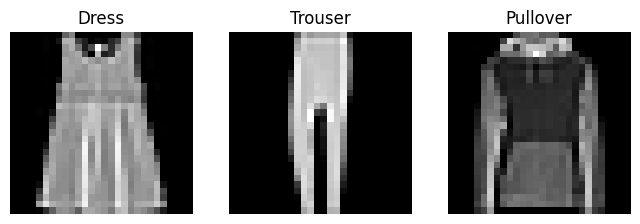

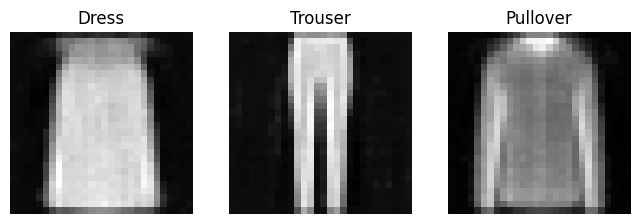

Epoch 20: 100%|██████████| 938/938 [00:21<00:00, 43.79it/s, loss : 773.87 | Global : 1735.40]


Epoch 21 Average loss : 0.7990
Test loss = 709.027447


Epoch 22: 100%|█████████▉| 937/938 [00:15<00:00, 79.89it/s, loss : 810.91 | Global : 1719.84] 

Epoch 22 Average loss : 0.8645
Test loss = 705.679851


Epoch 22: 100%|██████████| 938/938 [00:20<00:00, 44.96it/s, loss : 810.91 | Global : 1719.84]


Epoch 23 Average loss : 0.8250
Test loss = 707.016162


Epoch 24: 100%|█████████▉| 937/938 [00:15<00:00, 80.06it/s, loss : 755.87 | Global : 1706.27] 

Epoch 24 Average loss : 0.8058
Test loss = 697.428451


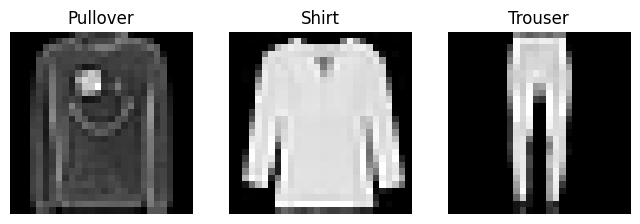

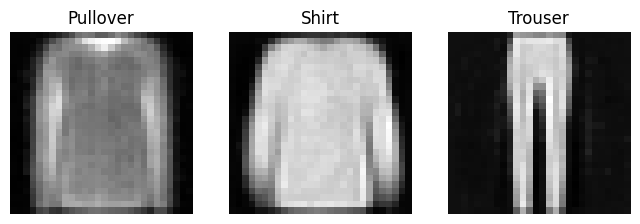

Epoch 24: 100%|██████████| 938/938 [00:21<00:00, 44.36it/s, loss : 755.87 | Global : 1706.27]


Epoch 25 Average loss : 0.8967
Test loss = 704.078862


Epoch 26: 100%|█████████▉| 937/938 [00:15<00:00, 79.77it/s, loss : 806.82 | Global : 1694.17] 

Epoch 26 Average loss : 0.8602
Test loss = 699.299089


Epoch 26: 100%|██████████| 938/938 [00:20<00:00, 44.90it/s, loss : 806.82 | Global : 1694.17]


Epoch 27 Average loss : 0.6992
Test loss = 700.404306


Epoch 28: 100%|██████████| 938/938 [00:15<00:00, 80.02it/s, loss : 774.88 | Global : 1683.36] 

Epoch 28 Average loss : 0.8261
Test loss = 691.699013


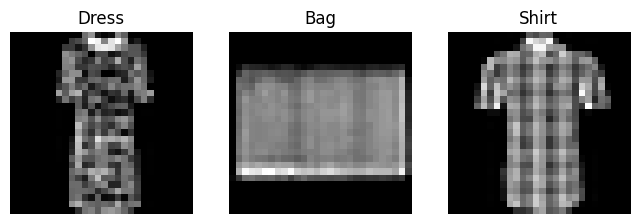

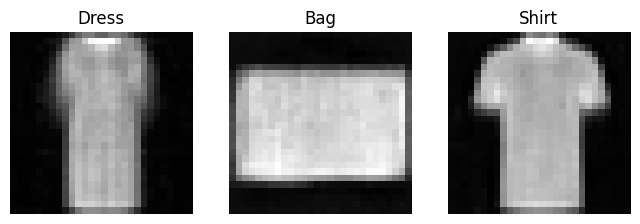

Epoch 28: 100%|██████████| 938/938 [00:21<00:00, 44.12it/s, loss : 774.88 | Global : 1683.36]


Epoch 29 Average loss : 0.8035
Test loss = 695.597703


Epoch 30: 100%|█████████▉| 937/938 [00:15<00:00, 78.51it/s, loss : 763.38 | Global : 1673.55] 

Epoch 30 Average loss : 0.8138
Test loss = 684.155711


Epoch 30: 100%|██████████| 938/938 [00:20<00:00, 45.42it/s, loss : 763.38 | Global : 1673.55]


Epoch 31 Average loss : 0.7560
Test loss = 685.541685


Epoch 32: 100%|█████████▉| 937/938 [00:15<00:00, 81.05it/s, loss : 800.26 | Global : 1664.63] 

Epoch 32 Average loss : 0.8532
Test loss = 686.133201


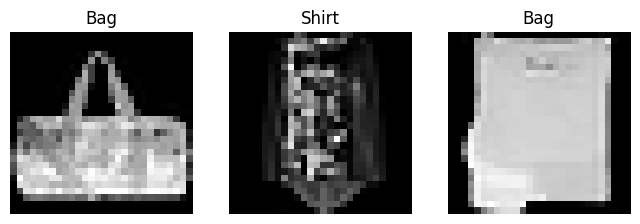

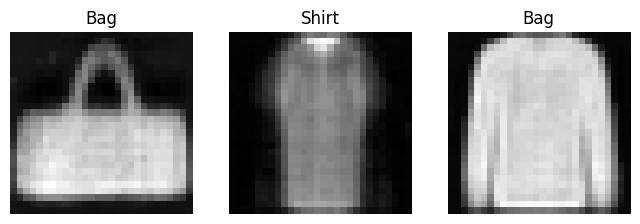

Epoch 32: 100%|██████████| 938/938 [00:21<00:00, 44.32it/s, loss : 800.26 | Global : 1664.63]


Epoch 33 Average loss : 0.7838
Test loss = 687.598276


Epoch 34: 100%|██████████| 938/938 [00:15<00:00, 78.29it/s, loss : 693.12 | Global : 1656.50] 

Epoch 34 Average loss : 0.7389
Test loss = 690.631392


Epoch 34: 100%|██████████| 938/938 [00:20<00:00, 45.40it/s, loss : 693.12 | Global : 1656.50]


Epoch 35 Average loss : 0.8953
Test loss = 691.309571


Epoch 36: 100%|█████████▉| 937/938 [00:15<00:00, 81.36it/s, loss : 721.31 | Global : 1648.98] 

Epoch 36 Average loss : 0.7690
Test loss = 685.078912


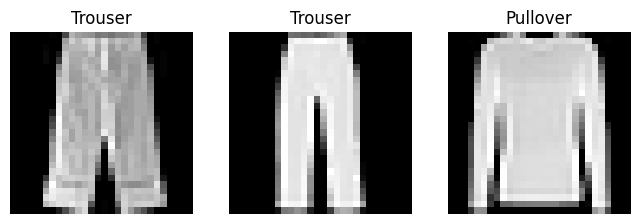

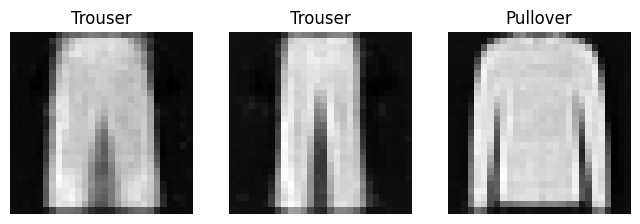

Epoch 36: 100%|██████████| 938/938 [00:21<00:00, 44.45it/s, loss : 721.31 | Global : 1648.98]


Epoch 37 Average loss : 0.9043
Test loss = 691.586920


Epoch 38: 100%|█████████▉| 937/938 [00:15<00:00, 80.66it/s, loss : 742.78 | Global : 1642.02] 

Epoch 38 Average loss : 0.7919
Test loss = 709.045720


Epoch 38: 100%|██████████| 938/938 [00:20<00:00, 45.24it/s, loss : 742.78 | Global : 1642.02]


Epoch 39 Average loss : 0.8633
Test loss = 683.652535


Epoch 40: 100%|█████████▉| 937/938 [00:15<00:00, 80.20it/s, loss : 708.37 | Global : 1635.56] 

Epoch 40 Average loss : 0.7552
Test loss = 682.534497


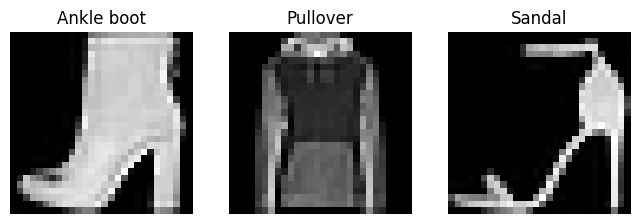

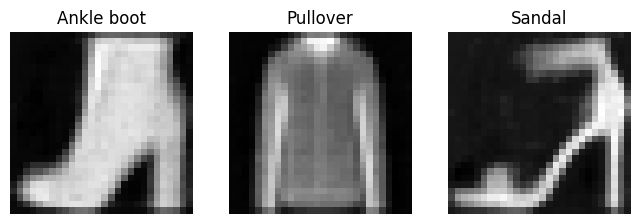

Epoch 40: 100%|██████████| 938/938 [00:21<00:00, 44.35it/s, loss : 708.37 | Global : 1635.56]


Epoch 41 Average loss : 0.7637
Test loss = 681.813237


Epoch 42: 100%|█████████▉| 937/938 [00:15<00:00, 82.46it/s, loss : 750.80 | Global : 1629.52] 

Epoch 42 Average loss : 0.8004
Test loss = 689.285527


Epoch 42: 100%|██████████| 938/938 [00:20<00:00, 45.27it/s, loss : 750.80 | Global : 1629.52]


Epoch 43 Average loss : 0.7315
Test loss = 690.431409


Epoch 44: 100%|██████████| 938/938 [00:15<00:00, 78.10it/s, loss : 661.38 | Global : 1623.85] 

Epoch 44 Average loss : 0.7051
Test loss = 690.890332


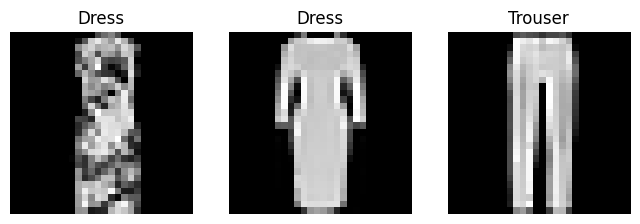

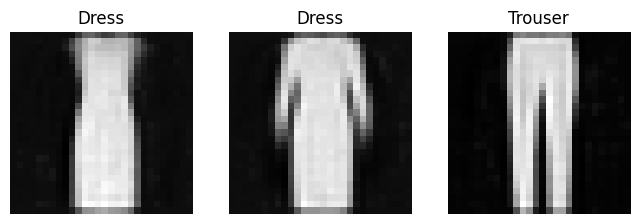

Epoch 44: 100%|██████████| 938/938 [00:21<00:00, 44.23it/s, loss : 661.38 | Global : 1623.85]


Epoch 45 Average loss : 0.7998
Test loss = 672.163602


Epoch 46: 100%|█████████▉| 937/938 [00:15<00:00, 79.29it/s, loss : 729.90 | Global : 1618.56] 

Epoch 46 Average loss : 0.7781
Test loss = 686.409890


Epoch 46: 100%|██████████| 938/938 [00:20<00:00, 45.23it/s, loss : 729.90 | Global : 1618.56]


Epoch 47 Average loss : 0.7242
Test loss = 679.150847


Epoch 48: 100%|█████████▉| 937/938 [00:15<00:00, 81.69it/s, loss : 780.73 | Global : 1613.56] 

Epoch 48 Average loss : 0.8323
Test loss = 677.051450


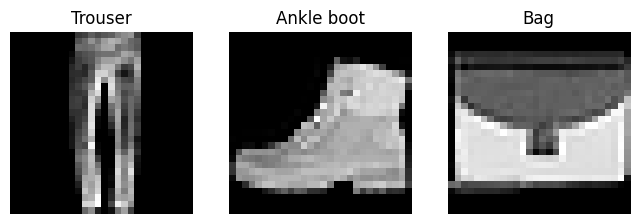

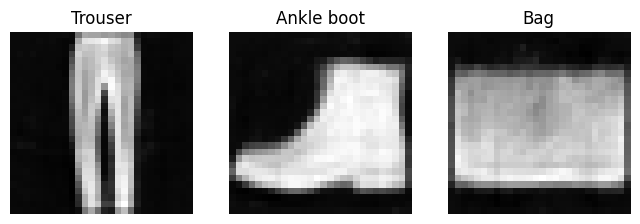

Epoch 48: 100%|██████████| 938/938 [00:21<00:00, 44.66it/s, loss : 780.73 | Global : 1613.56]


Epoch 49 Average loss : 0.7408
Test loss = 671.957172


In [ ]:

global_loss = 0
global_step = 0

for epoch in range(-1, epochs):
    if epoch >= 0:
        fashion_vae.train()
        train_loss = 0
        
        pbar = tqdm(total=len(fashion_train), desc=f"Epoch {epoch}")
        
        for x, _ in fashion_train:
            x = x.to(device)
            
            x_hat, mu, logvar = fashion_vae(x)
            loss = VAE_loss(x_hat, x, mu, logvar)
            train_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            global_step += 1
            global_loss += loss.item()
            
            pbar.set_postfix_str(f"loss : {loss.item():.2f} | Global : {global_loss/global_step:.2f}")
            pbar.update(1)
            
        print(f"Epoch {epoch} Average loss : {loss.item()/len(fashion_train):.4f}")
            
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        fashion_vae.eval()
        test_loss = 0
        for x, y in fashion_test:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = fashion_vae(x)
            test_loss += VAE_loss(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
            
        print(f"Test loss = {test_loss/len(fashion_test):4f}")
    
        epoch_data['mu'].append(torch.cat(means))
        epoch_data['logvar'].append(torch.cat(logvars))
        epoch_data['loss'].append(test_loss)
        epoch_data['labels'].append(torch.cat(labels)) 
            
        if epoch%4 == 0:
            plot_sample(x.cpu(), y, num_images=3, class_names=class_names)
            plot_sample(x_hat.detach().cpu(), y, num_images=3, class_names=class_names)
            

In [ ]:
gensamps = fashion_vae.generate(10)

Some samples using random points in the latent space

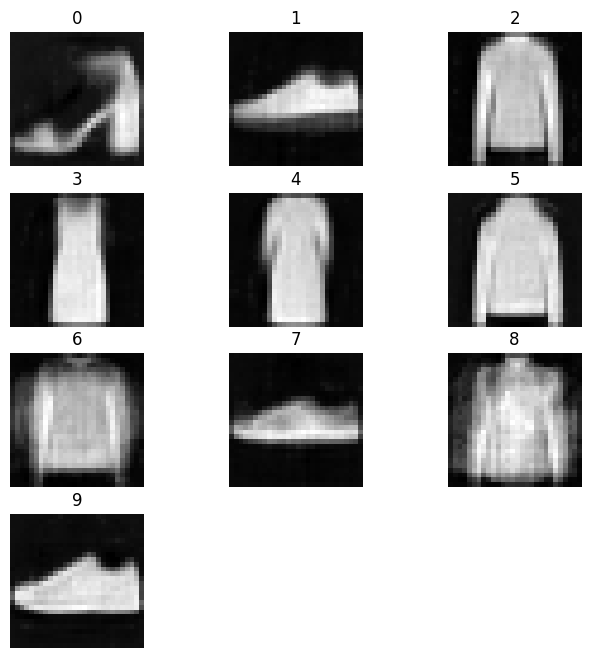

In [ ]:
plot_sample(gensamps.cpu().detach(), torch.arange(10), num_images=10)

Below, the latent representation for some images is calculated. Then the intermediated interpolations between those is calculated and then decoded.

In [ ]:
a = next(iter(fashion_test))

In [ ]:
fashion_vae.eval()

a1 = a[0][10:17]
a2 = a[0][20:27]

# a1_enc = fashion_vae.encoder(a1)
mu_logvar = fashion_vae.encoder(a1.to(device).view(-1, 1, 28, 28))
a1_enc, _ = torch.chunk(mu_logvar, chunks=2, dim=1)

mu_logvar = fashion_vae.encoder(a2.to(device).view(-1, 1, 28, 28))
a2_enc, _ = torch.chunk(mu_logvar, chunks=2, dim=1)

In [ ]:
intermediates = torch.tensor(np.array([torch.lerp(a1_enc.detach().cpu(), a2_enc.detach().cpu(), w).numpy() for w in np.arange(0, 1.1, 0.1)])).permute(1,0,2)

intermediates_dec = fashion_vae.decoder((intermediates).reshape(-1, 50).to(device)).detach().cpu()
# intermediates.shape

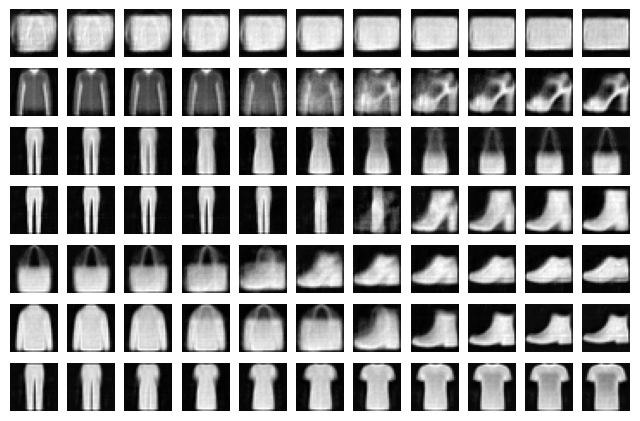

In [ ]:
plot_sample(intermediates_dec, None, (8,6), 77, 11)

# GAN
GAN trainied to generate the MNIST dataset

## GAN architecture


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim) -> None:
        super(Discriminator, self).__init__()

        self.conv_dim = conv_dim

        self.conv1 = nn.Sequential(nn.Conv2d(1, conv_dim, kernel_size=5, stride=2, padding=1),
                                   nn.LeakyReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(conv_dim, conv_dim*2, kernel_size=3, stride=2, padding=1),
                                   nn.BatchNorm2d(conv_dim*2),
                                   nn.LeakyReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=3, stride=2, padding=1),
                                   nn.BatchNorm2d(conv_dim*4),
                                   nn.LeakyReLU(inplace=True))
        self.conv4 = nn.Sequential(nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=3, stride=2, padding=1),
                                   nn.BatchNorm2d(conv_dim*8),
                                   nn.LeakyReLU(inplace=True))
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(conv_dim*8*2*2, 10),
                                nn.LeakyReLU(inplace=True), nn.Linear(10, 1))


    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.fc(x)

        return  x

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, conv_dim) -> None:
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.z_dim = z_dim
        
        self.fc = nn.Sequential(nn.Linear(z_dim, conv_dim*4*3*3),nn.LeakyReLU(), nn.Dropout(0.2))
        
        self.up_conv1 = nn.Sequential(nn.ConvTranspose2d(conv_dim*4, conv_dim*4, 5, 2, padding = 1),
                                      nn.BatchNorm2d(conv_dim*4),
                                      nn.LeakyReLU(),
                                      nn.Dropout(0.2))
        self.up_conv2 = nn.Sequential(nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, 2, padding = 1),
                                      nn.BatchNorm2d(conv_dim*2),
                                      nn.LeakyReLU(),
                                      nn.Dropout(0.2))
        self.up_conv3 = nn.Sequential(nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, 2, padding = 1),
                                      nn.BatchNorm2d(conv_dim),
                                      nn.LeakyReLU(),
                                      nn.Dropout(0.2))
        
        self.final_conv = nn.Conv2d(conv_dim, 1, 1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 3,3)
        
        x = self.up_conv1(x)
        x = self.up_conv2(x)
        x = self.up_conv3(x)
        
        x = self.final_conv(x)
        x = F.tanh(x)
        
        return x

## MNIST Dataset

In [ ]:
# set input as image dims and output as number of classes
input_size = 28 * 28
output_size = 10

# loading the train and test datasets into datalaoder
mnist_train = DataLoader(
    datasets.MNIST(
        root="../data", train=True, download=True, transform=ToTensor()
    ),
    batch_size=128,
    shuffle=True,
    num_workers=4
)

In [ ]:
a = next(iter(mnist_train))

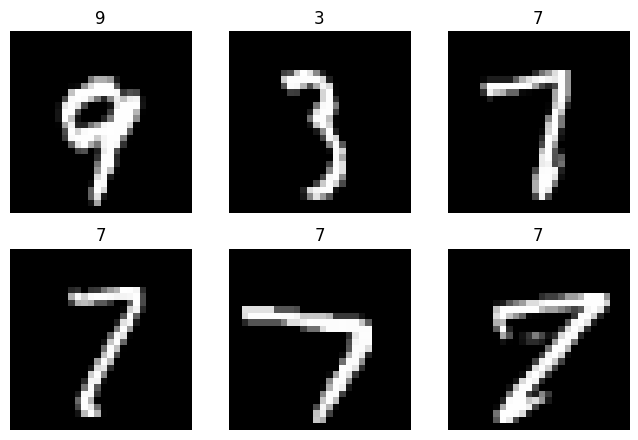

In [ ]:
plot_sample(a[0], a[1])

In [ ]:
discriminator = Discriminator(64).to(device)
generator = Generator(128, 64).to(device)

In [ ]:
def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

In [ ]:
discriminator.apply(weights_init)
generator.apply(weights_init)

Generator(
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=2304, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
  )
  (up_conv1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (up_conv2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (up_conv3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Drop

In [ ]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), 2e-4, (0.5,0.999)) # for discriminator
generator_optimizer = torch.optim.Adam(generator.parameters(), 2e-4, (0.5,0.999)) # for generator

In [ ]:
def real_loss(D_out, smooth = False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)

    if smooth:
        labels = torch.ones(batch_size, device=device)*0.9
    else:
        labels = torch.ones(batch_size, device=device)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)

    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size, device=device)

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
def train(D, G, z_size, n_epochs):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = torch.rand((sample_size, z_size), device=device)*2 -1

    # epoch training loop
    for epoch in range(n_epochs):

        pbar = tqdm(total=len(mnist_train), desc=f"Epoch {epoch}")

        # batch training loop
        for batchid, (real_images, _) in enumerate(mnist_train):

            batch_size = real_images.size(0)
            real_images = real_images.view(-1, 1, 28, 28).to(device)

            # Train the discriminator on real and fake images

            discriminator_optimizer.zero_grad()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)      # Calculates log(D(x))

            z = torch.rand((batch_size, z_size), device=device)*2 -1

            fake_images = G(z)

            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            d_loss = d_real_loss + d_fake_loss

            if batchid % 2 == 0:
                d_loss.backward()
                discriminator_optimizer.step()

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()

            z = torch.rand((batch_size, z_size), device=device)*2 -1

            fake_images = G(z)

            D_fake = D(fake_images)

            g_loss = real_loss(D_fake)  # The Generator wishies to minimize the real_loss for it's fake output
                                        # to trick the Discriminator

            g_loss.backward()
            generator_optimizer.step()

            losses.append((d_loss.item(), g_loss.item()))

            pbar.update(1)
            pbar.set_postfix_str(f"d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}")

        pbar.close()
        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        if epoch % 5 == 0:
            plot_sample(samples_z.cpu().detach(), num_cols=4, num_images=16)
        G.train() # back to training mode

    # finally return losses
    return losses

Epoch 0: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s, d_loss: 0.6664 | g_loss: 1.6119]


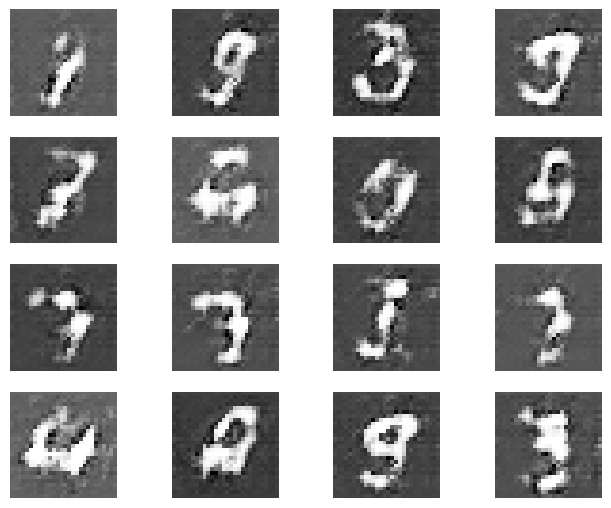

Epoch 5: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s, d_loss: 0.6104 | g_loss: 1.4020]


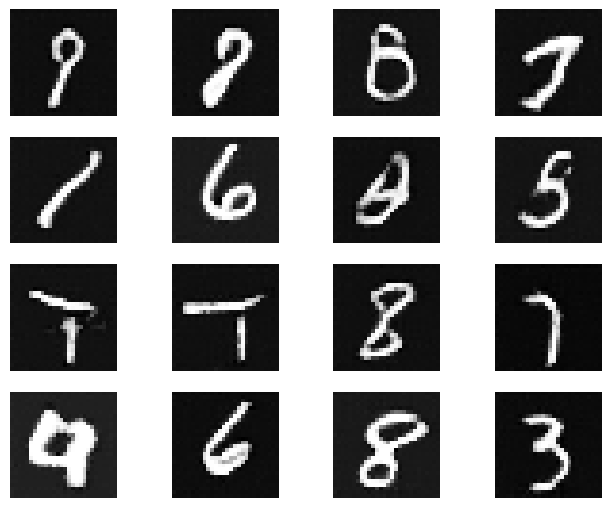

Epoch 10: 100%|██████████| 469/469 [00:20<00:00, 23.18it/s, d_loss: 0.5585 | g_loss: 1.5544]


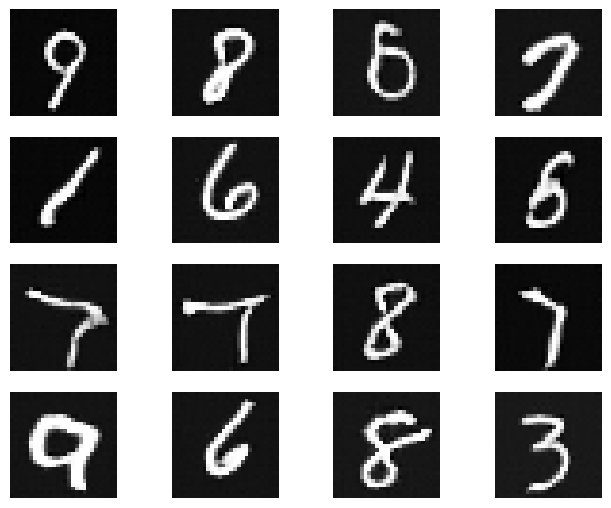

Epoch 15: 100%|██████████| 469/469 [00:20<00:00, 23.13it/s, d_loss: 0.5505 | g_loss: 3.3116]


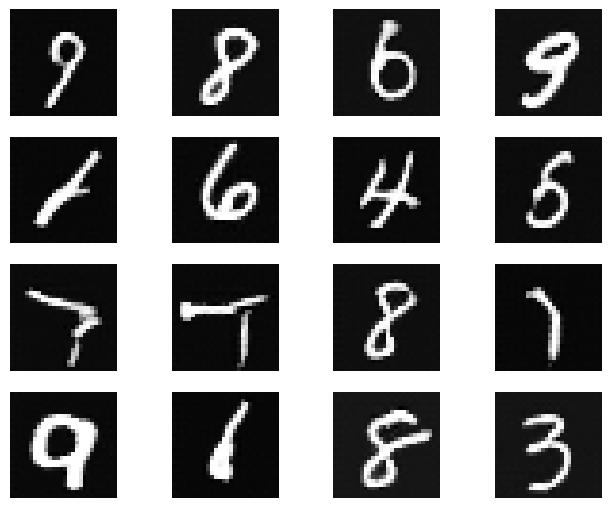

Epoch 20: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s, d_loss: 0.0726 | g_loss: 3.6214] 


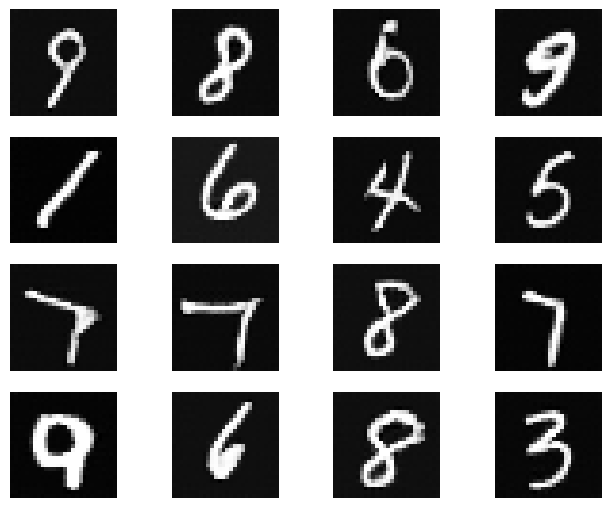

Epoch 25: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s, d_loss: 0.2637 | g_loss: 4.9465]


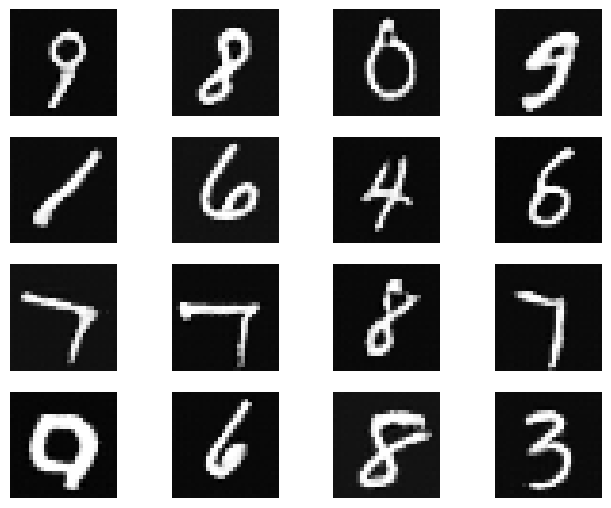

Epoch 30: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s, d_loss: 0.0432 | g_loss: 4.5506]


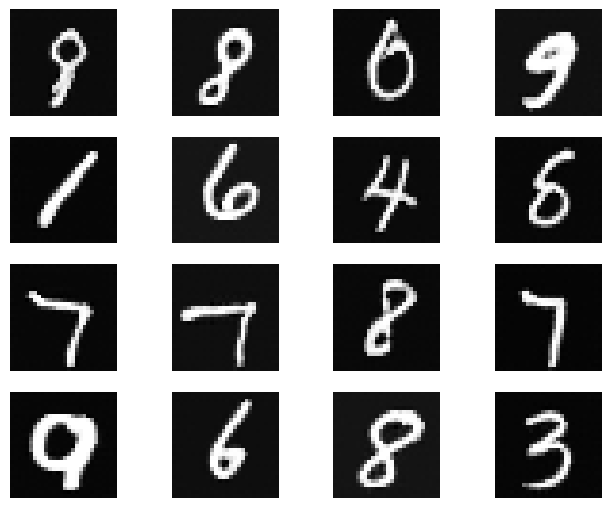

Epoch 35: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s, d_loss: 2.6543 | g_loss: 8.2498] 


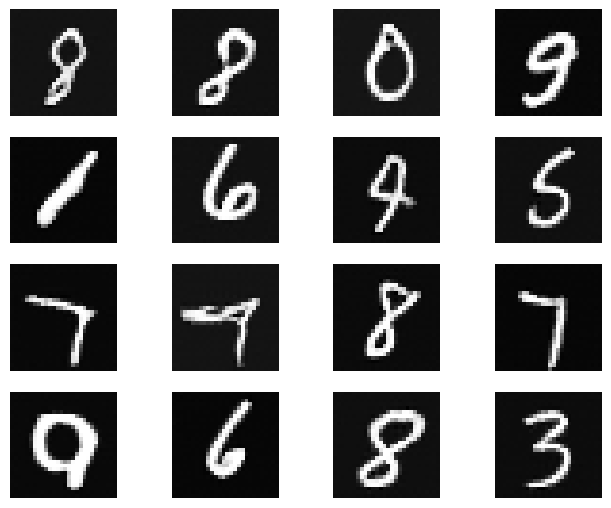

Epoch 40: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s, d_loss: 0.0155 | g_loss: 4.8405] 


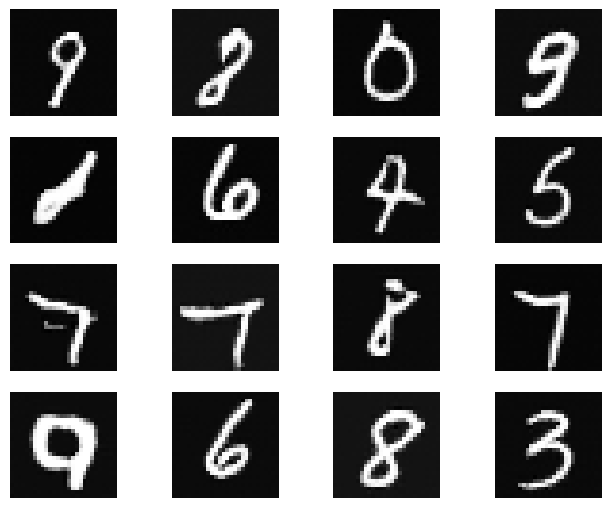

Epoch 45: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s, d_loss: 0.0414 | g_loss: 6.6999]


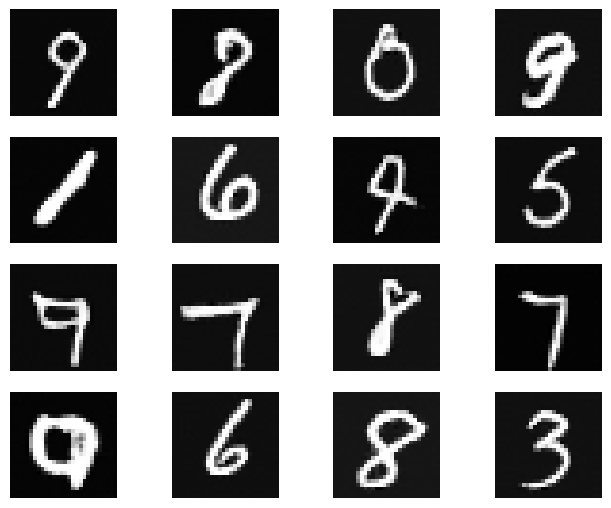

Epoch 50: 100%|██████████| 469/469 [00:20<00:00, 23.17it/s, d_loss: 0.0775 | g_loss: 3.2892] 


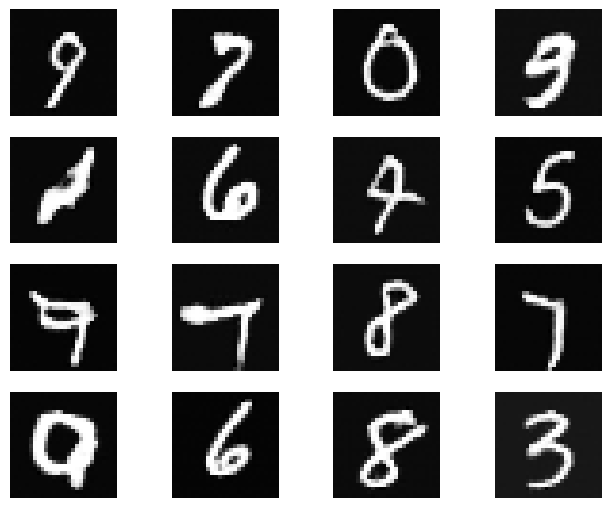

Epoch 55: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s, d_loss: 0.0404 | g_loss: 5.2135] 


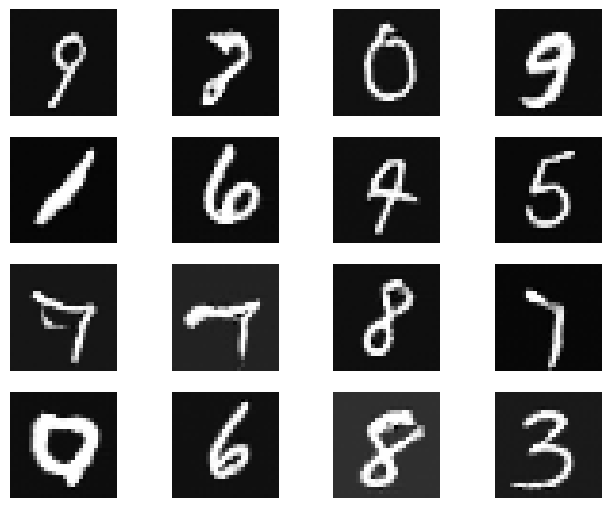

Epoch 60: 100%|██████████| 469/469 [00:20<00:00, 23.14it/s, d_loss: 0.0211 | g_loss: 5.2259]


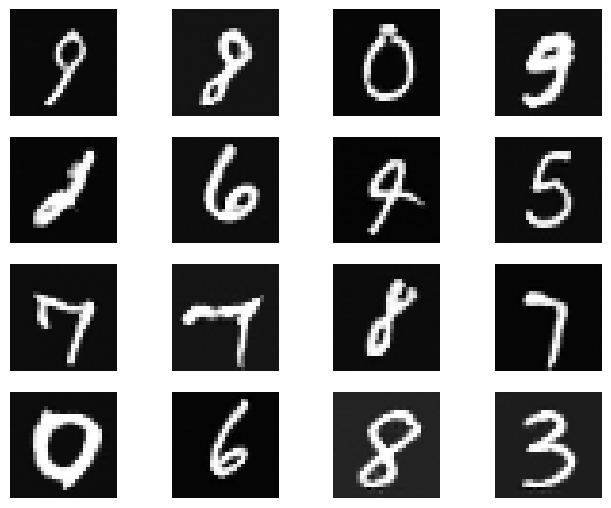

Epoch 65: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s, d_loss: 0.0243 | g_loss: 6.4078] 


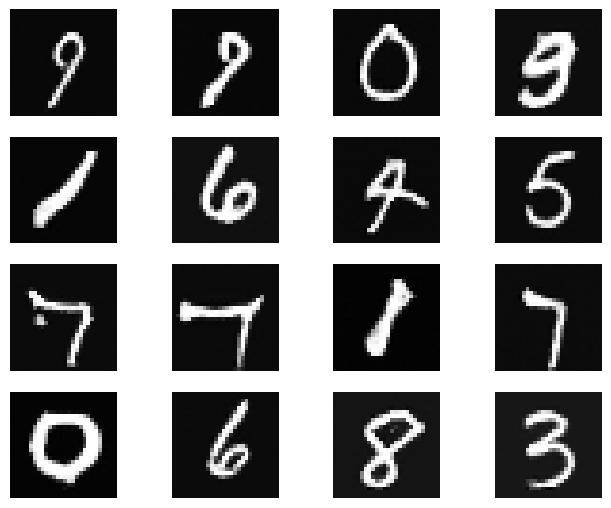

Epoch 70: 100%|██████████| 469/469 [00:20<00:00, 23.21it/s, d_loss: 0.0023 | g_loss: 4.7784]


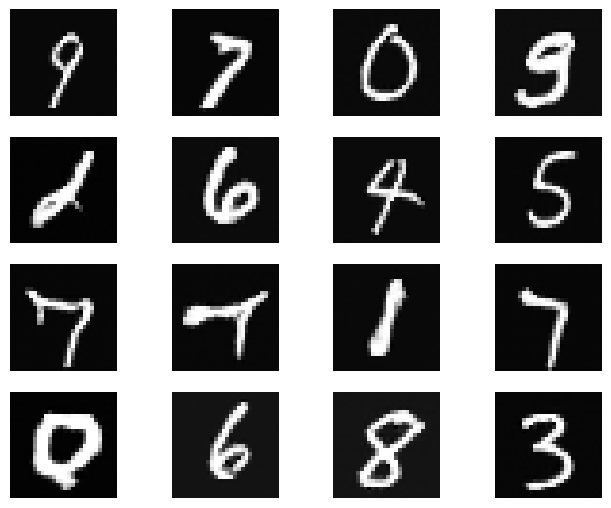

Epoch 75: 100%|██████████| 469/469 [00:20<00:00, 23.15it/s, d_loss: 0.0247 | g_loss: 6.8684] 


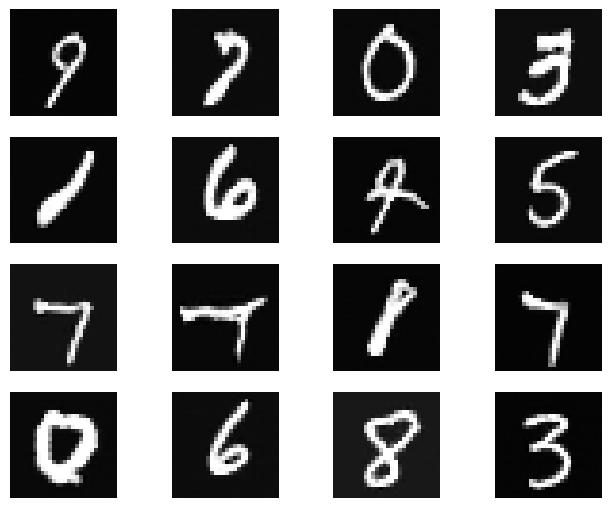

Epoch 80: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s, d_loss: 0.0222 | g_loss: 6.7801]


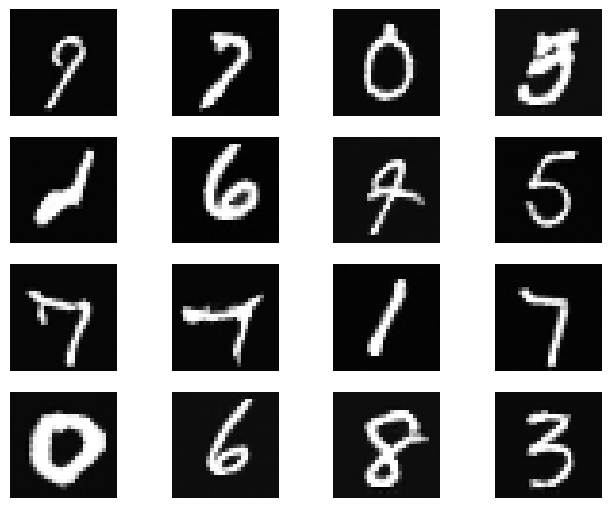

In [ ]:
losses = train(discriminator, generator, 128, 81)

In [ ]:
sample_size=49
fixed_z = torch.rand((sample_size, 128), device=device)*2 -1

generator.eval() # for generating samples
samples_z = generator(fixed_z)

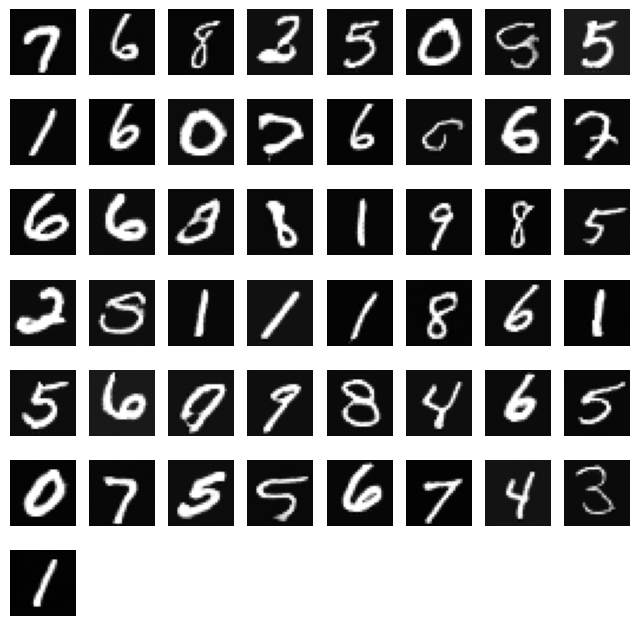

In [ ]:
plot_sample(samples_z.cpu().detach(), num_cols=8, num_images=49)

In [ ]:
generator.eval()

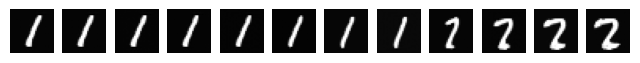

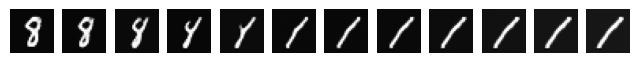

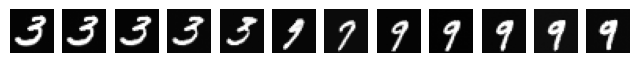

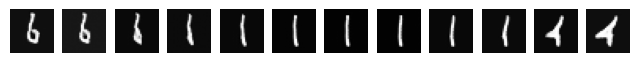

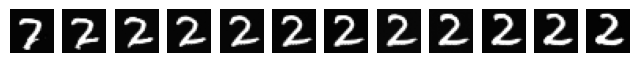

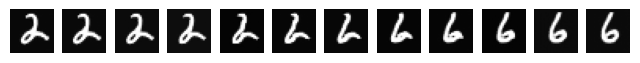

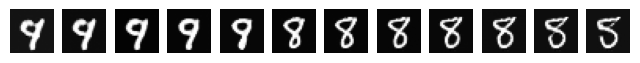

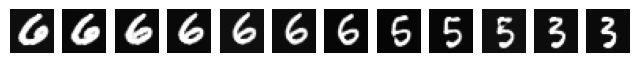

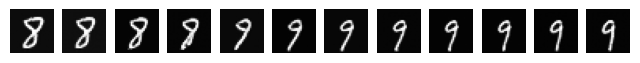

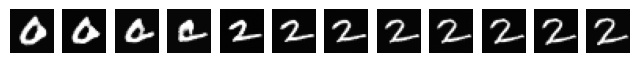

In [ ]:
for _ in range(10):
    a = torch.rand(128)*2-1
    b = torch.rand(128)*2-1

    intermediates = torch.tensor(np.array([torch.lerp(a, b, w).numpy() for w in np.arange(0, 1.05, 1/11)]))

    generated = generator(intermediates.to(device))

    plot_sample(generated.detach().cpu(), None, (8,6), 12, 12)

# CGAN
CGAN to generate the MNIST dataset, for a supplied class


## CGAN architecture

In [ ]:
class Cond_Discriminator(nn.Module):
    def __init__(self, conv_dim, num_classes,  emb_dim) -> None:
        super(Cond_Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.emb = nn.Sequential(nn.Linear(num_classes, emb_dim), nn.LeakyReLU())
        
        self.emb_2 = nn.Sequential(nn.Linear(emb_dim, 784), nn.LeakyReLU())
        
        self.conv1 = nn.Sequential(nn.Conv2d(2, conv_dim, kernel_size=5, stride=2, padding=1),
                                   nn.LeakyReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv2d(conv_dim, conv_dim*2, kernel_size=3, stride=2, padding=1),
                                   nn.BatchNorm2d(conv_dim*2),
                                   nn.LeakyReLU(inplace=True))
        self.conv3 = nn.Sequential(nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=3, stride=2, padding=1),
                                   nn.BatchNorm2d(conv_dim*4),
                                   nn.LeakyReLU(inplace=True))
        self.conv4 = nn.Sequential(nn.Conv2d(conv_dim*4, conv_dim*8, kernel_size=3, stride=2, padding=1),
                                   nn.BatchNorm2d(conv_dim*8),
                                   nn.LeakyReLU(inplace=True))
        self.fc = nn.Sequential(nn.Flatten(), nn.Linear(conv_dim*8*2*2, 10),
                                nn.LeakyReLU(inplace=True), nn.Linear(10, 1))
        
        
    def forward(self, x, y):
        
        y = self.emb(y)
        y = (self.emb_2(y)).view(-1, 1, 28, 28)
        
        x = torch.cat((x,y), dim=-3)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = self.fc(x)
        
        return  x

In [ ]:
class Cond_Generator(nn.Module):
    def __init__(self, z_dim, conv_dim, num_classes,  emb_dim) -> None:
        super(Cond_Generator, self).__init__()
        self.conv_dim = conv_dim
        self.z_dim = z_dim
        
        self.emb = nn.Sequential(nn.Linear(num_classes, emb_dim), nn.LeakyReLU())
        self.emb_2 = nn.Sequential(nn.Linear(emb_dim, 4*4), nn.LeakyReLU())
        self.fc = nn.Sequential(nn.Linear(z_dim , conv_dim*4*4), nn.LeakyReLU())
        
        self.up_conv1 = nn.Sequential(nn.Upsample(scale_factor=2), 
                                      nn.Conv2d(conv_dim+1, conv_dim, kernel_size=3, padding=1),
                                      nn.Conv2d(conv_dim, conv_dim, kernel_size=1),
                                      nn.BatchNorm2d(conv_dim),
                                      nn.LeakyReLU(inplace=True))
        self.up_conv2 = nn.Sequential(nn.Upsample(scale_factor=2), 
                                      nn.Conv2d(conv_dim, conv_dim, kernel_size=3, padding=1),
                                      nn.Conv2d(conv_dim, conv_dim, kernel_size=1),
                                      nn.BatchNorm2d(conv_dim),
                                      nn.LeakyReLU(inplace=True))
        self.up_conv3 = nn.Sequential(nn.Upsample(scale_factor=2),
                                      nn.Conv2d(conv_dim, conv_dim, kernel_size=3, padding=1),
                                      nn.Conv2d(conv_dim, conv_dim, kernel_size=1),
                                      nn.BatchNorm2d(conv_dim),
                                      nn.LeakyReLU(inplace=True))
        
        self.final_conv = nn.Conv2d(conv_dim, 1, 1)
        
    def forward(self, x, y):
        y = self.emb(y)
        y = self.emb_2(y)
        y = y.view(-1, 1, 4,4)
        
        x = self.fc(x)
        x = x.view(-1, self.conv_dim, 4,4)
        
        x = torch.cat((x,y), dim=-3)
        
        x = self.up_conv1(x)
        x = self.up_conv2(x)
        x = self.up_conv3(x)
        
        # the result of conv is 32x32, this crops it to 28x28
        x = F.center_crop(x, 28)
        
        x = self.final_conv(x)
        x = F.tanh(x)
        
        return x

In [ ]:
cdiscriminator = Cond_Discriminator(64,10, 50).to(device)
cgenerator = Cond_Generator(128, 128,10, 40).to(device)

In [ ]:
# custom weights initialization
def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

In [ ]:
cdiscriminator.apply(weights_init)
cgenerator.apply(weights_init)

Generator(
  (emb): Sequential(
    (0): Linear(in_features=10, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (emb_2): Sequential(
    (0): Linear(in_features=40, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=2048, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (up_conv1): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(129, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (up_conv2): Sequential(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (3): BatchNorm2d(128, eps=

In [ ]:
discriminator_optimizer = torch.optim.Adam(cdiscriminator.parameters(), 2e-4, betas=(0.5, 0.999)) # for discriminator
generator_optimizer = torch.optim.Adam(cgenerator.parameters(), 2e-4, betas=(0.5, 0.999)) # for generator

In [ ]:
# defining one hot vectors so that numbers can be converted to onehot pretty fast

onehot = torch.zeros(10, 10).scatter_(1, torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1)

In [ ]:
def train(D, G, z_size, n_epochs):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=40
    fixed_z = torch.rand((sample_size, z_size), device=device)*2 -1
    fixed_y = onehot[torch.tensor([*range(10)] * 4)].to(device)
    fixed_labels = torch.tensor([*range(10)] * 4
)
    # epoch training loop
    for epoch in range(n_epochs):
        
        pbar = tqdm(total=len(mnist_train), desc=f"Epoch {epoch}")

        # batch training loop
        for batchid, (real_images, real_labels) in enumerate(mnist_train):

            batch_size = real_images.size(0)
            
            # ones and zeros to calculate loss
            # label_ones = torch.ones((batch_size, 1), device=device) * 0.9
            # label_zeros = torch.ones((batch_size, 1), device=device) * 0.1
            
            real_images = real_images.view(-1, 1, 28, 28).to(device)
            real_labels = onehot[real_labels].to(device)

            # Train the discriminator on real and fake images
            
            discriminator_optimizer.zero_grad()
                
            D_real = D(real_images, real_labels)
            # d_real_loss = criterion(D_real, label_ones)      # Calculates log(D(x))
            d_real_loss = real_loss(D_real)

            z = torch.rand((batch_size, z_size), device=device)*2 - 1
            y = onehot[torch.randint(0, 10, (batch_size,))].to(device)
                
            fake_images = G(z, y)
            
            D_fake = D(fake_images, y)
            d_fake_loss = fake_loss(D_fake)
            
            d_loss = d_real_loss + d_fake_loss
            
            # if batchid % 2 == 0:
            d_loss.backward()
            discriminator_optimizer.step()     

            # 2. Train the generator with an adversarial loss
            generator_optimizer.zero_grad()
            
            z = torch.rand((batch_size, z_size), device=device)*2 -1
            y = onehot[torch.randint(0, 10, (batch_size,))].to(device)
            
            fake_images = G(z, y)
            
            D_fake = D(fake_images, y)
            
            g_loss = real_loss(D_fake)                            
        
            g_loss.backward()
            generator_optimizer.step()
            
            losses.append((d_loss.item(), g_loss.item()))
            
            pbar.update(1)
            pbar.set_postfix_str(f"d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}")

        pbar.close()
        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z, fixed_y)
        samples.append(samples_z)
        if epoch % 5 == 0:
            plot_sample(samples_z.cpu().detach(), label_batch=fixed_labels, num_cols=10, num_images=40, figsize=(20, 8))
        G.train() # back to training mode
    
    # finally return losses
    return losses

Epoch 0: 100%|██████████| 469/469 [00:21<00:00, 21.60it/s, d_loss: 0.4561 | g_loss: 3.8671]


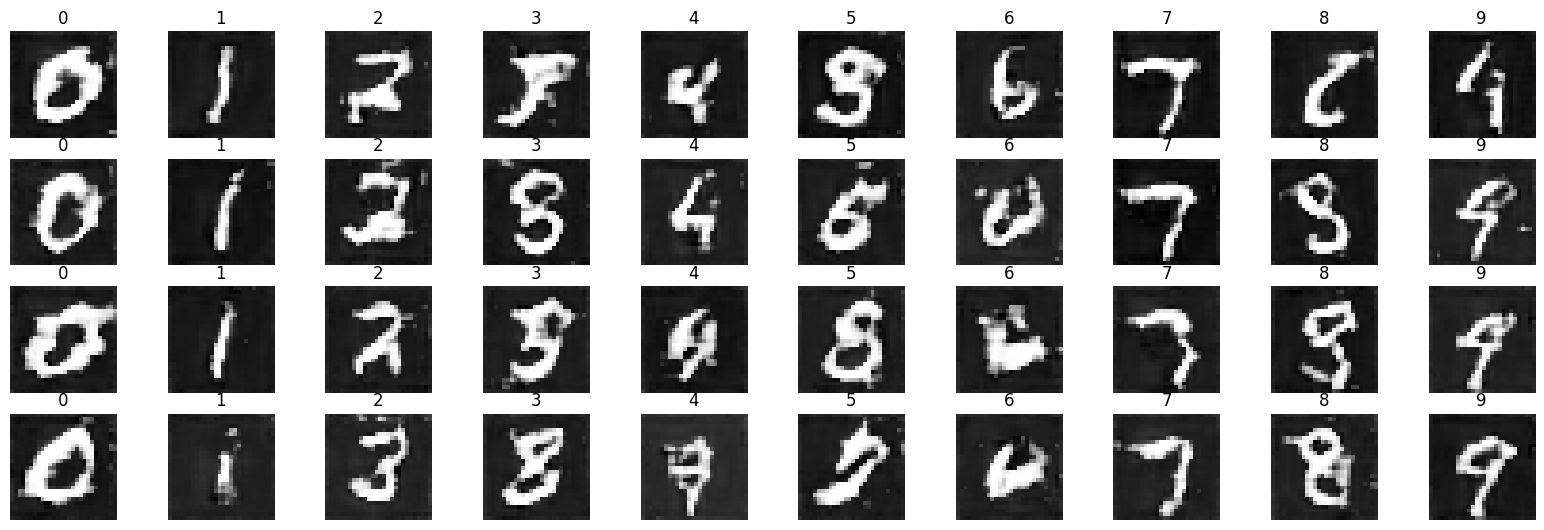

Epoch 5: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s, d_loss: 2.0824 | g_loss: 2.1404] 


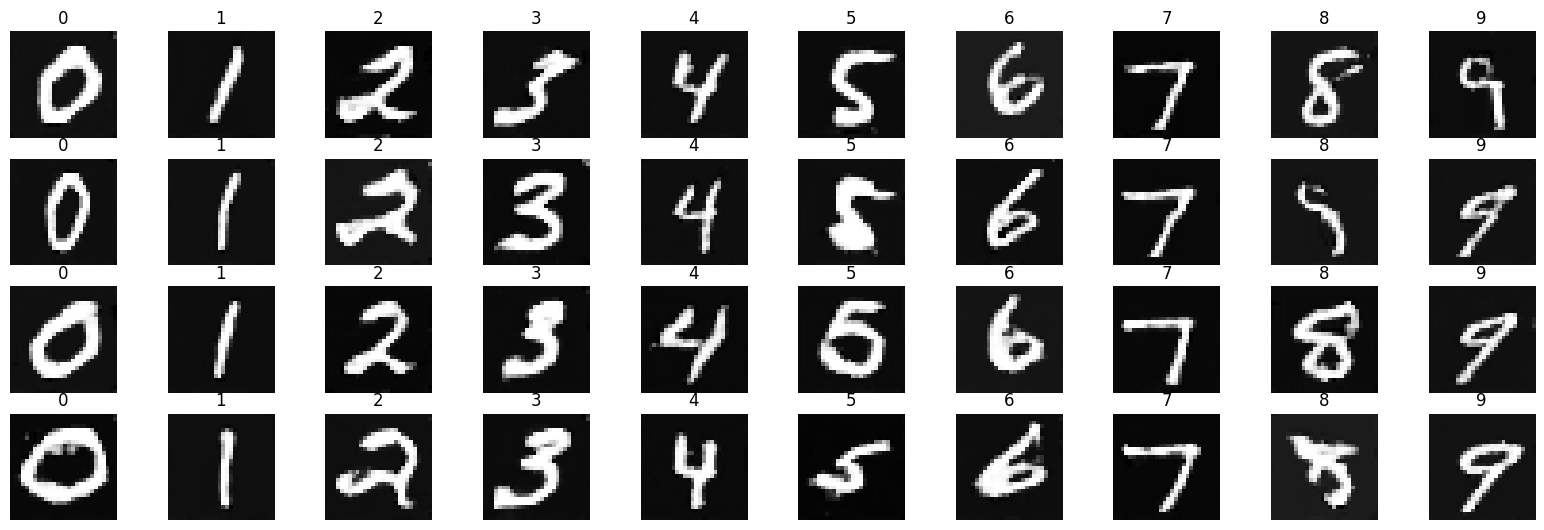

Epoch 10: 100%|██████████| 469/469 [00:22<00:00, 21.13it/s, d_loss: 0.7565 | g_loss: 7.7349] 


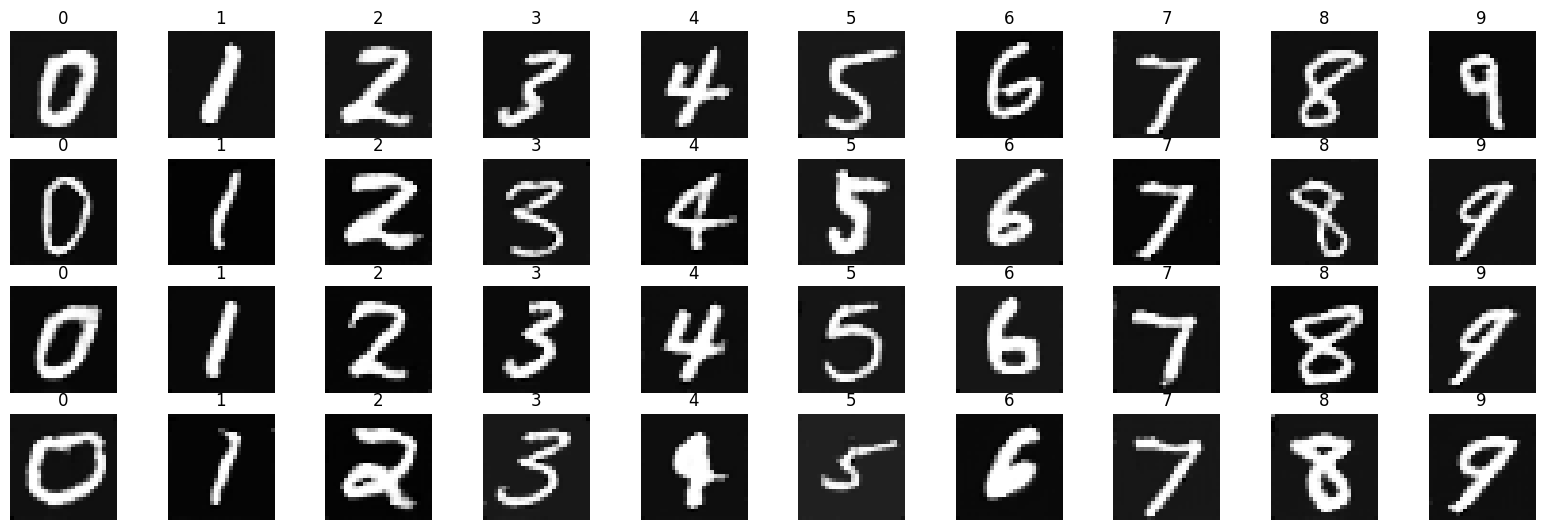

Epoch 15: 100%|██████████| 469/469 [00:21<00:00, 21.47it/s, d_loss: 0.5242 | g_loss: 7.7714] 


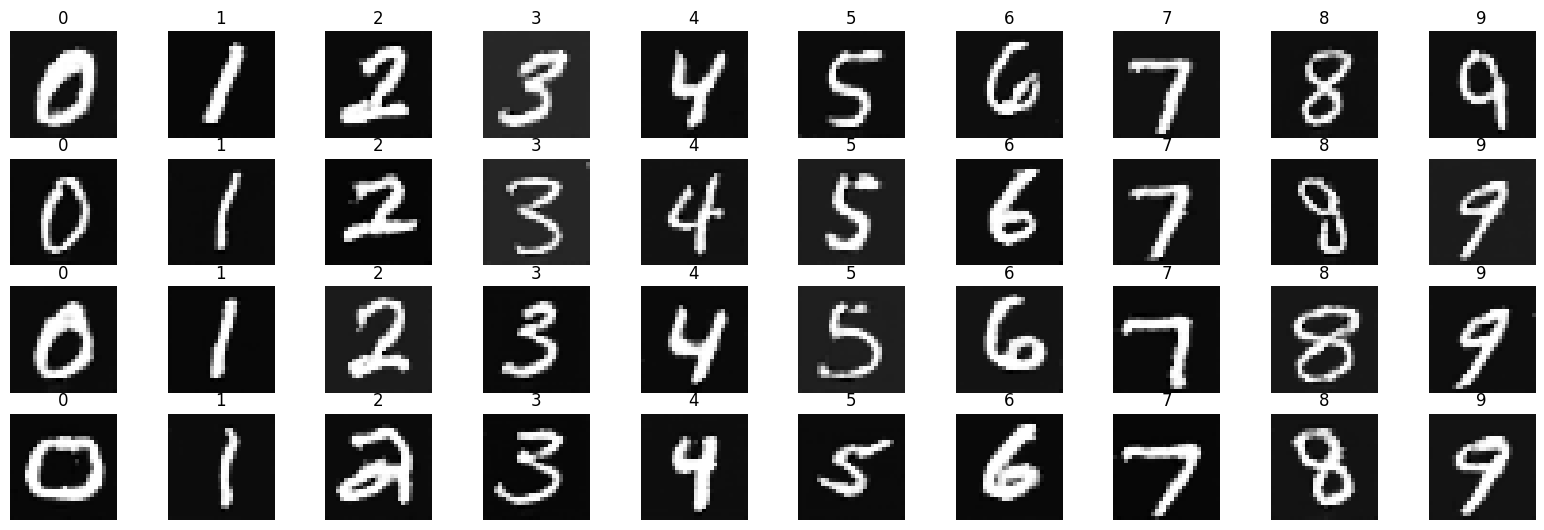

Epoch 20: 100%|██████████| 469/469 [00:21<00:00, 21.45it/s, d_loss: 0.0688 | g_loss: 8.6526] 


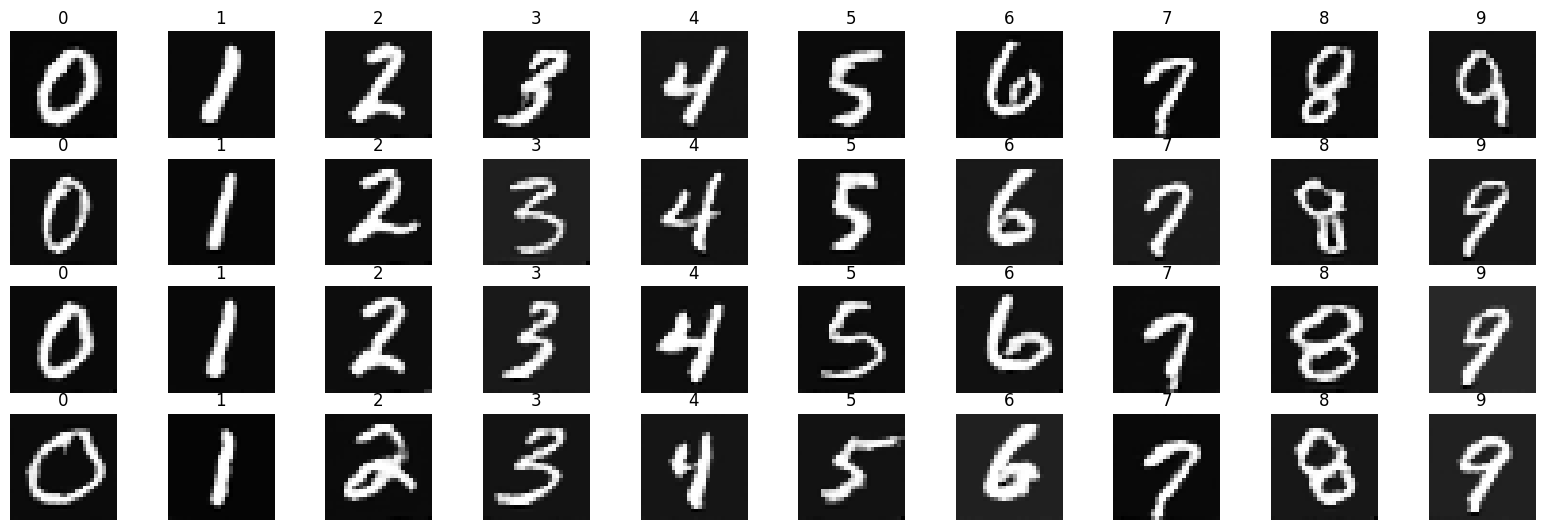

In [ ]:
losses = train(cdiscriminator, cgenerator, 128, 16)

In [ ]:
sample_size=40
fixed_z = torch.rand((sample_size, 128), device=device)*2 -1
fixed_y = onehot[torch.tensor([*range(10)] * 4)].to(device)
fixed_labels = torch.tensor([*range(10)] * 4)

cgenerator.eval() # for generating samples
samples_z = cgenerator(fixed_z, fixed_y)

## Plotting some samples for each class

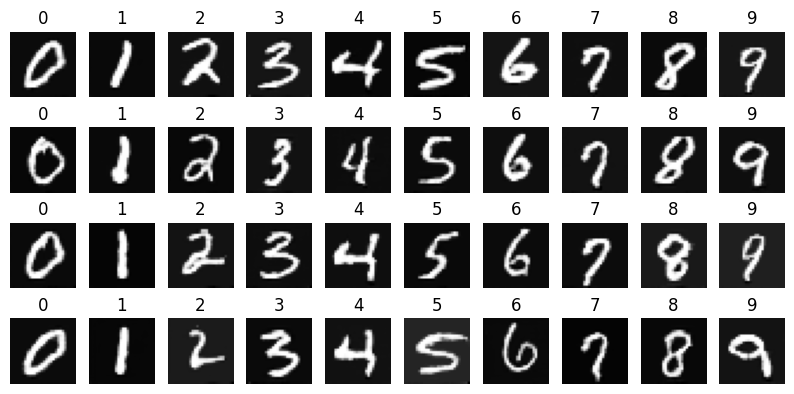

In [ ]:
plot_sample(samples_z.cpu().detach(),label_batch=fixed_labels, num_cols=10, num_images=40, figsize=(10,6))